In [138]:
!pip install deeplake
!pip install scipy
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install --upgrade setuptools
!pip install --upgrade scikit-learn
!pip install --upgrade tensorflow
!pip install --upgrade certifi

In [139]:
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import deeplake
from PIL import Image
import matplotlib.pyplot as plt
import os
from scipy.ndimage import rotate
import random
import ssl
import certifi

ssl_context = ssl.create_default_context(cafile=certifi.where())

In [140]:
# Load MNIST dataset

(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

In [141]:
# Load USPS dataset
# https://datasets.activeloop.ai/docs/ml/datasets/usps-dataset/
usps_train = deeplake.load('hub://activeloop/usps-train')
usps_test = deeplake.load('hub://activeloop/usps-test')

|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/usps-train



\

hub://activeloop/usps-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/usps-test



-

hub://activeloop/usps-test loaded successfully.



In [142]:
usps_train_images = usps_train['images'].numpy()
usps_train_labels = usps_train['labels'].numpy().flatten()
usps_test_images = usps_test['images'].numpy()
usps_test_labels = usps_test['labels'].numpy().flatten()

usps_image_shape = usps_test_images[0].shape
mnist_image_shape = mnist_train_images[0].shape

vert_pad = (mnist_image_shape[0] - usps_image_shape[0]) // 2
horz_pad = (mnist_image_shape[1] - usps_image_shape[1]) // 2

usps_train_images = np.pad(usps_train_images, ((0, 0), (vert_pad, vert_pad), (horz_pad, horz_pad)), mode='constant', constant_values=0)
usps_test_images = np.pad(usps_test_images, ((0, 0), (vert_pad, vert_pad), (horz_pad, horz_pad)), mode='constant', constant_values=0)

In [143]:
# Print a single image and label pair
def print_image(image, label):

  print(f'The following is a {label}:')

  for row in image:
    r = ''
    for pixel in row:
      if pixel == 0:
        r = r + '  '
      else:
        r = r + '##'
    print(r)


# Print multiple image and label pairs
def print_images(images, labels):

  if len(images) != len(labels):
    return

  for i in range(len(images)):
    print_image(images[i], labels[i])


# Plot handwritten images in a grid
def plot_images_in_grid(images, labels, grid_size, size=3, n_th=0, false_labels=np.array([])):

  if false_labels is None:
      false_labels = []
  start_image = n_th * grid_size[0] * grid_size[1]

  fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(size * grid_size[1], size * grid_size[0]))

  if grid_size[0] < 2:
    axes = np.ravel(axes)

  for i in range(grid_size[0]):
    for j in range(grid_size[1]):

      index = start_image + i * grid_size[1] + j
      current_axes = axes[j] if grid_size[0] < 2 else axes[i, j]

      current_axes.imshow(images[index], cmap='gray')
      if false_labels.size == 0:
        current_axes.set_title(labels[index])
      else:
        current_axes.set_title(f'Actual: {labels[index]}, Guessed: {false_labels[index]}')
      current_axes.axis('off')

  plt.show()

In [144]:
# Helper function to rotate an image by a give degree
def rotate_image(image, degree):

  rotated_image = rotate(image, degree, reshape=False, mode='nearest')

  return rotated_image

# Adds a random rotation to handwritten images
def add_random_rotation(images):

  rotated_images = np.copy(images)
  for i in range(len(images)):
    angle = random.uniform(0, 360)
    rotated_images[i] = rotate_image(images[i], angle)
  return rotated_images


In [145]:
# Helper to add random noise to handwritten image
def create_noise(shape, noise_level, noise_probability, noise_constant):

  if random.random() < noise_probability:

    if noise_constant:
      noise_level_t = noise_level
    else:
      noise_level_t = random.uniform(0, noise_level)

    noise = np.random.normal(0, noise_level_t, shape)

  else:
    noise = np.zeros(shape)

  return noise

# Adds random noise to handwritten images
def add_random_noise(images, noise_level, noise_probability=1, noise_constant=True):

  image_shape = images[0].shape

  noisy_images = np.copy(images)
  noise = [create_noise(image_shape, noise_level, noise_probability, noise_constant) for _ in range(len(images))]
  noisy_images = noisy_images + noise
  noisy_images = np.clip(noisy_images, 0, 255)

  return noisy_images

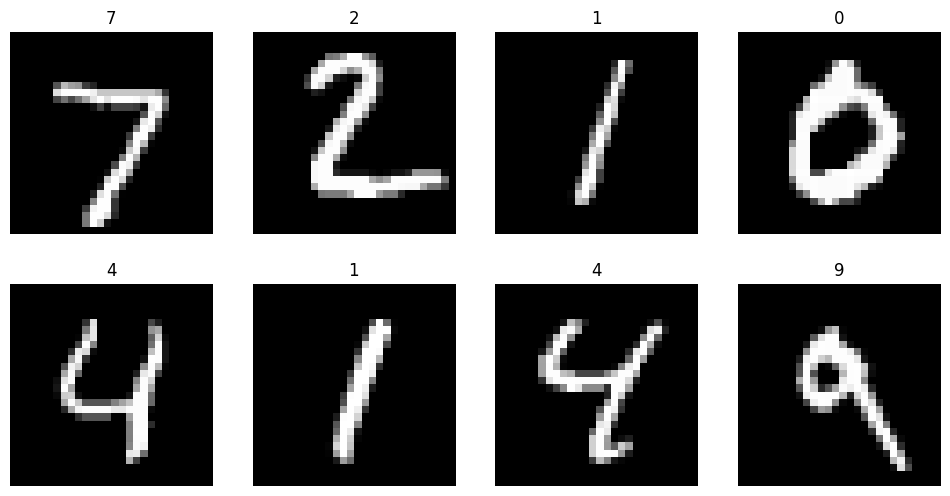

In [146]:
# Print out elements from MNIST dataset
plot_images_in_grid(mnist_test_images, mnist_test_labels, (2, 4))

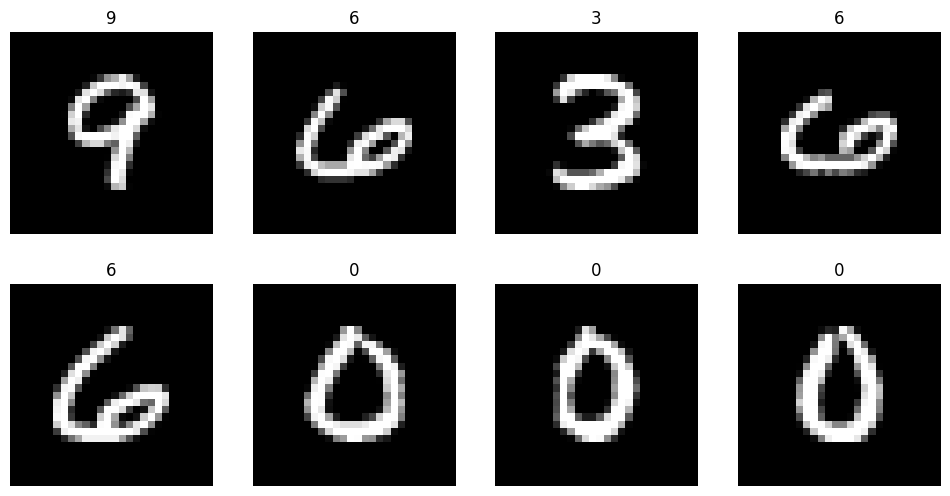

In [147]:
# Print out elements from USPS dataset
plot_images_in_grid(usps_test_images, usps_test_labels, (2,4))

In [148]:
# Add random noise to some of the handwritten digits
NOISE_MAX = 100
NOISE_PROB = 0.75
NOISE_CONST = False

mnist_noisy_train_images = add_random_noise(mnist_train_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)
mnist_noisy_test_images = add_random_noise(mnist_test_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

usps_noisy_train_images = add_random_noise(usps_train_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)
usps_noisy_test_images = add_random_noise(usps_test_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

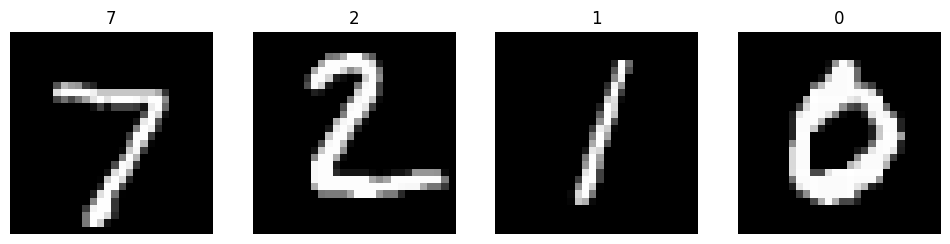

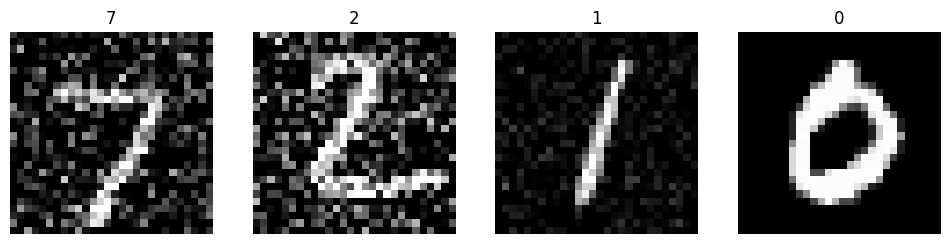

In [149]:
# Print out new versus original elements from MNIST dataset
plot_images_in_grid(mnist_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy_test_images, mnist_test_labels, (1,4))

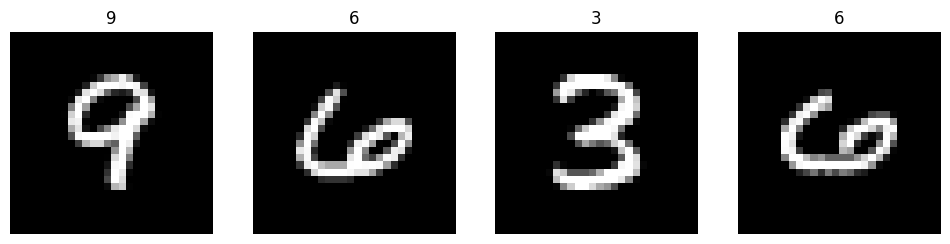

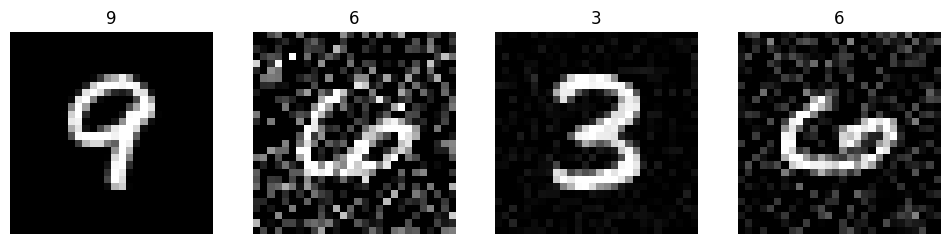

In [150]:
# Print out new versus original elements from USPS dataset
plot_images_in_grid(usps_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy_test_images, usps_test_labels, (1,4))

In [151]:
# Create various other datasets for testing

# 25% max noise
mnist_noisy25_test_images = add_random_noise(mnist_test_images, NOISE_MAX // 4)
usps_noisy25_test_images = add_random_noise(usps_test_images, NOISE_MAX // 4)

# 50% max noise
mnist_noisy50_test_images = add_random_noise(mnist_test_images, NOISE_MAX // 2)
usps_noisy50_test_images = add_random_noise(usps_test_images, NOISE_MAX // 2)

# 100% max noise
mnist_noisy100_test_images = add_random_noise(mnist_test_images, NOISE_MAX)
usps_noisy100_test_images = add_random_noise(usps_test_images, NOISE_MAX)

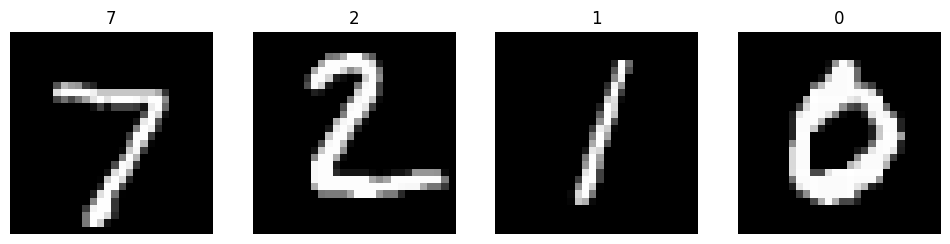

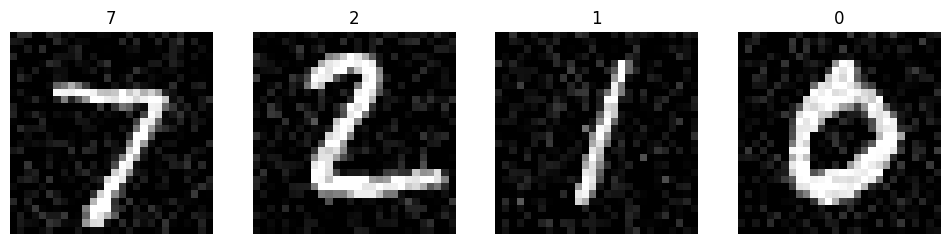

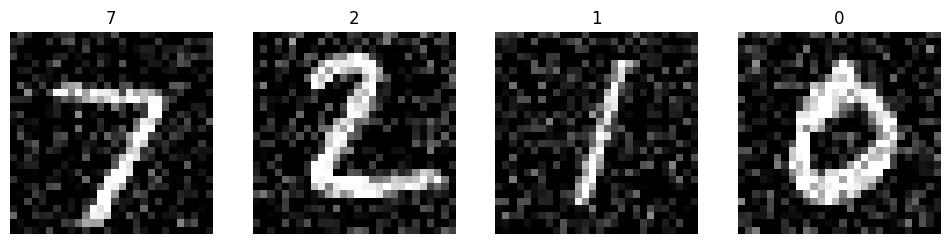

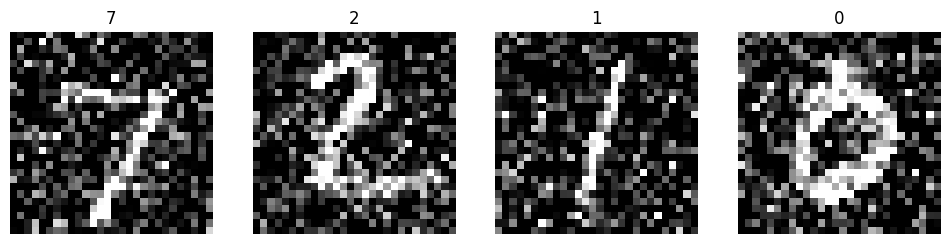

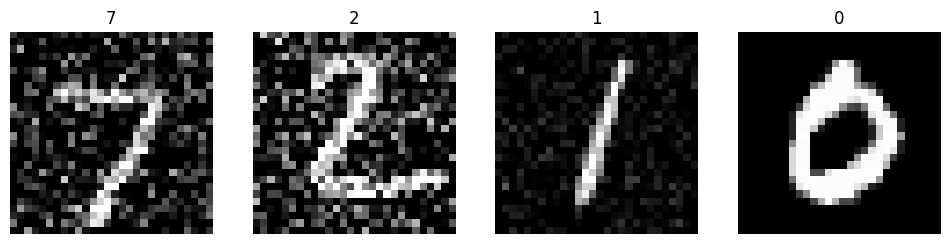

In [152]:
# Plot all the different testing datasets from MNIST
plot_images_in_grid(mnist_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy25_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy50_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy100_test_images, mnist_test_labels, (1,4))
plot_images_in_grid(mnist_noisy_test_images, mnist_test_labels, (1,4))

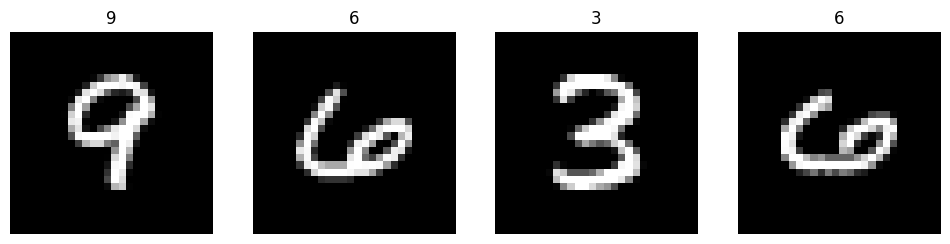

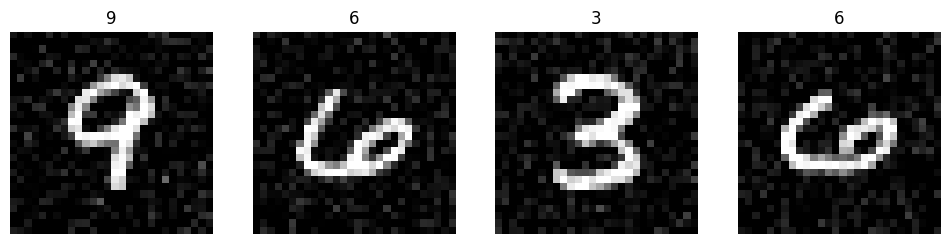

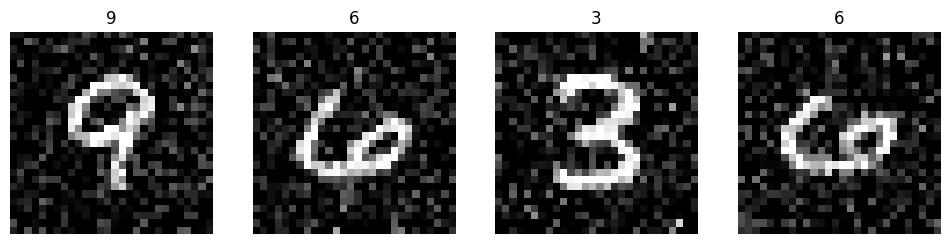

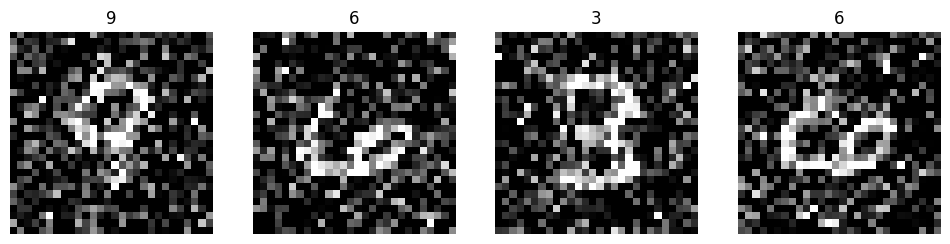

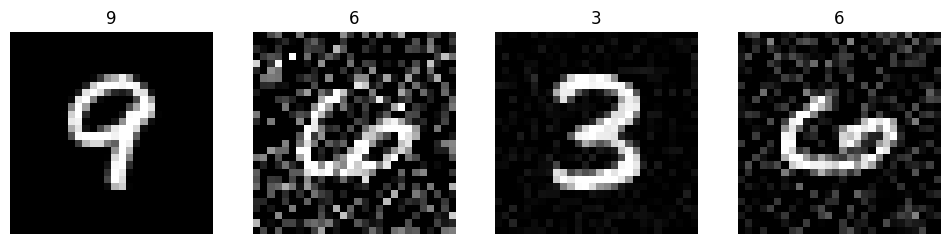

In [153]:
# Plot all the different testing datasets from USPS
plot_images_in_grid(usps_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy25_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy50_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy100_test_images, usps_test_labels, (1,4))
plot_images_in_grid(usps_noisy_test_images, usps_test_labels, (1,4))

In [154]:
# Combine the training datasets from MNIST and USPS
combined_train_images = np.vstack((mnist_train_images, usps_train_images))
combined_test_images = np.vstack((mnist_test_images, usps_test_images))

combined_noisy_train_images = np.vstack((mnist_noisy_train_images, usps_noisy_train_images))
combined_noisy_test_images = np.vstack((mnist_noisy_test_images, usps_noisy_test_images))

combined_train_labels = np.append(mnist_train_labels, usps_train_labels)
combined_test_labels = np.append(mnist_test_labels, usps_test_labels)

# Combined rotated noisy and non noisy for use later
combined_rotated_train_images = add_random_rotation(combined_train_images)
combined_rotated_test_images = add_random_rotation(combined_test_images)

combined_rotated_noisy_train_images = add_random_noise(combined_rotated_train_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)
combined_rotated_noisy_test_images = add_random_noise(combined_rotated_test_images, NOISE_MAX, NOISE_PROB, NOISE_CONST)

In [155]:
# Get statistics for a dataset
def get_statistics(training_labels, testing_labels, name, get_split = False):

  training_counts = np.bincount(training_labels)
  testing_counts = np.bincount(testing_labels)
  full_counts = training_counts + testing_counts

  # Create labels for graph
  labels = [i for i in range(10)]

  # Create a bar graph
  plt.bar(labels, training_counts, label='Training Set', color='blue')
  plt.bar(labels, testing_counts, bottom=training_counts, label='Testing Set', color='orange')
  plt.xticks(np.arange(len(labels)), labels)

  # Add axis titles and a main title
  plt.xlabel('Digit')
  plt.ylabel('Count')
  plt.title(name)

  plt.legend()

  # Show the plot
  plt.show()

  if get_split:
    print(f'Showing statistics for full {name} dataset:')
    print(f' {len(training_labels) + len(testing_labels)} total rows:')
    for digit in range(len(full_counts)):
      print(f'   {digit}: {full_counts[digit]} ({100 * (full_counts[digit]/(len(training_labels) + len(testing_labels))):.3f}%)')

    print(f'Showing statistics for {name} training dataset:')
    print(f' {len(training_labels)} total rows:')
    for digit in range(len(training_counts)):
      print(f'   {digit}: {training_counts[digit]} ({100 * (training_counts[digit]/len(training_labels)):.3f}%)')

    print(f'Showing statistics for {name} training dataset:')
    print(f' {len(testing_labels)} total rows:')
    for digit in range(len(testing_counts)):
      print(f'   {digit}: {testing_counts[digit]} ({100 * (testing_counts[digit]/len(testing_labels)):.3f}%)')


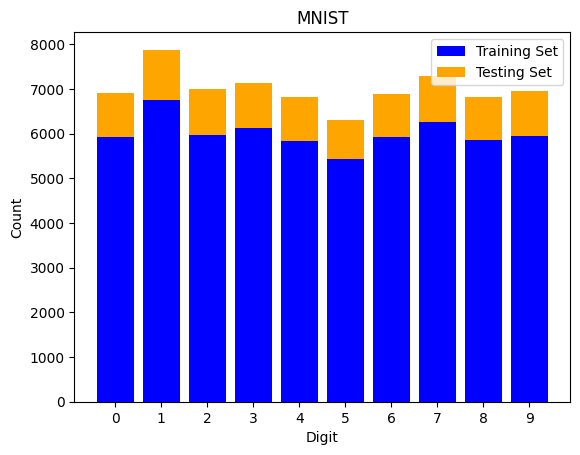

In [156]:
# Statistics about MNIST TODO
get_statistics(mnist_train_labels, mnist_test_labels, 'MNIST')

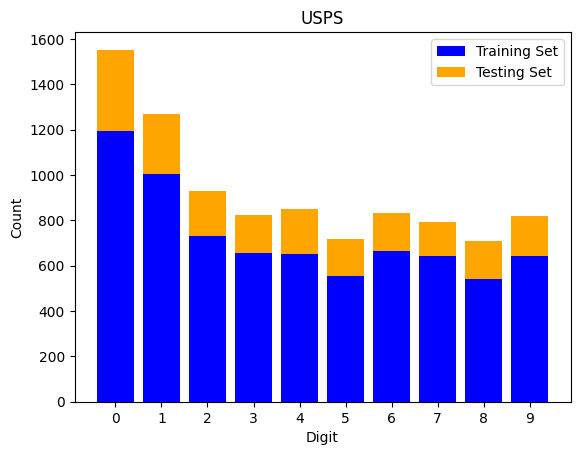

In [157]:
# Statistics about USPS TODO
get_statistics(usps_train_labels, usps_test_labels, 'USPS')

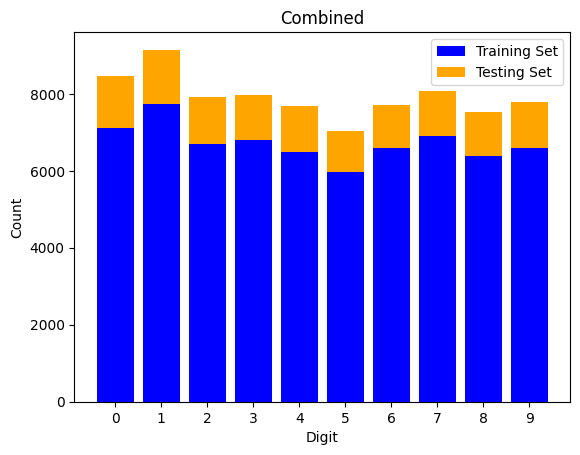

In [158]:
get_statistics(combined_train_labels, combined_test_labels, 'Combined')

In [159]:
input_shape = mnist_image_shape

LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 15

# Define the CNN model
model = models.Sequential()

model.add(layers.Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape))

# Convolution Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before the fully connected layers
model.add(layers.Flatten())

# Fully Connected Layer 1
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

/Users/amoskowitz/Desktop/Projects/HandwrittenDigitClassification/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
# Evaluates the model using test images and labels
def eval_model(my_model, test_images, test_labels, name):
  test_predictions = my_model.predict(test_images)
  test_predictions_classes = tf.argmax(test_predictions, axis=1)

  accuracy = accuracy_score(test_labels, test_predictions_classes)
  precision = precision_score(test_labels, test_predictions_classes, average='weighted')
  recall = recall_score(test_labels, test_predictions_classes, average='weighted')
  f1 = f1_score(test_labels, test_predictions_classes, average='weighted')

  print(f'Testing Done Using {name} Dataset:')
  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-Score: {f1:.4f}')


# Evaluates the model using each of the testing and training labels
def eval_all(my_model, include_rotated=False):
  print('MNIST:')
  eval_model(my_model, mnist_test_images, mnist_test_labels, 'MNIST Clean')
  eval_model(my_model, mnist_noisy_test_images, mnist_test_labels, 'MNIST Mixed')
  eval_model(my_model, mnist_noisy25_test_images, mnist_test_labels, 'MNIST 25%')
  eval_model(my_model, mnist_noisy50_test_images, mnist_test_labels, 'MNIST 50%')
  eval_model(my_model, mnist_noisy100_test_images, mnist_test_labels, 'MNIST 100%')

  print('\nUSPS:')
  eval_model(my_model, usps_test_images, usps_test_labels, 'USPS Clean')
  eval_model(my_model, usps_noisy_test_images, usps_test_labels, 'USPS Mixed')
  eval_model(my_model, usps_noisy25_test_images, usps_test_labels, 'USPS 25%')
  eval_model(my_model, usps_noisy50_test_images, usps_test_labels, 'USPS 50%')
  eval_model(my_model, usps_noisy100_test_images, usps_test_labels, 'USPS 100%')

  print('\nCombined:')
  eval_model(my_model, combined_test_images, combined_test_labels, 'Combined Clean')
  eval_model(my_model, combined_noisy_test_images, combined_test_labels, 'Combined Mixed')

  if include_rotated:
    eval_model(my_model, combined_rotated_test_images, combined_test_labels, 'Combined Clean Rotated')
    eval_model(my_model, combined_rotated_noisy_test_images, combined_test_labels, 'Combined Mixed Rotated')

In [161]:
# Finds the accuracy of a model
def find_accuracy(my_model, test_images, test_labels):
  test_predictions = my_model.predict(test_images)
  test_predictions_classes = tf.argmax(test_predictions, axis=1)

  accuracy = accuracy_score(test_labels, test_predictions_classes)
  return accuracy

# Trains a fit for the model and returns it accuracy
def train_fit(my_model, train_images, train_labels, test_images, test_labels, epochs, batch_size, learning_rate):

  # create a new model for each itteration
  trial_model = clone_model(my_model)
  trial_model.set_weights(model.get_weights())
  trial_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  trial_model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))
  return find_accuracy(trial_model, test_images, test_labels)

# Finds the optimal epochs, batch size, and learning rate for the model and returns the model
def find_optimal_fit(my_model, train_images, train_labels, test_images, test_labels):

  max_trials = 3
  epoch_options = [5, 10, 15, 20]
  batch_sizes = [16, 32, 64, 128]
  learning_rates = [0.01, 0.001, 0.0001, 0.00001]

  last_epochs = -1
  last_batch_size = -1
  last_learning_rate = -1

  best_epochs = epoch_options[0]
  best_batch_size = batch_sizes[0]
  best_learning_rate = learning_rates[0]

  ret = np.array([])

  # Run through each trial itteration to optimize hyperparameters
  for trial in range(1, max_trials + 1):

    print(f'Trial {trial}:')

    epoch_acc = 0
    batch_size_acc = 0
    learning_rate_acc = 0

    # optimize learning rate
    print(f'Optimizing learning rate with epochs: {best_epochs} and batch size {best_batch_size}')
    for cur_learning_rate in learning_rates:
      print(f'Testing learning rate = {cur_learning_rate} with epochs: {best_epochs} and batch size: {best_batch_size}')
      cur_acc = train_fit(my_model, train_images, train_labels, test_images, test_labels, best_epochs, best_batch_size, cur_learning_rate)

      # new best
      if cur_acc > learning_rate_acc:
        learning_rate_acc = cur_acc
        best_learning_rate = cur_learning_rate

    # optimize batch size
    print(f'Optimizing batch size with epochs: {best_epochs} and learning rate {best_learning_rate}')
    for cur_batch_size in batch_sizes:
      print(f'Testing batch size = {cur_batch_size} with epochs: {best_epochs} and learning rate {best_learning_rate}')
      cur_acc = train_fit(my_model, train_images, train_labels, test_images, test_labels, best_epochs, cur_batch_size, best_learning_rate)

      # new best
      if cur_acc > batch_size_acc:
        batch_size_acc = cur_acc
        best_batch_size = cur_batch_size

    # optimize epochs
    print(f'Optimizing epochs with batch size: {best_batch_size} and learning rate {best_learning_rate}')
    for cur_epochs in epoch_options:
      print(f'Testing epochs = {cur_epochs} with batch size: {best_batch_size} and learning rate {best_learning_rate}')
      cur_acc = train_fit(my_model, train_images, train_labels, test_images, test_labels, cur_epochs, best_batch_size, best_learning_rate)

      # new best
      if cur_acc > epoch_acc:
        epoch_acc = cur_acc
        best_epochs = cur_epochs


    print(f'Hyperparameters after trail {trial}:\nEpochs: {best_epochs}\nBatch Size: {best_batch_size}\nLearning Rate: {best_learning_rate}')

    ret = np.append(ret, (best_epochs, best_batch_size, best_learning_rate, learning_rate_acc))

    # Jump out if nothing is changing
    if last_epochs == best_epochs and last_batch_size == best_batch_size and last_learning_rate == best_batch_size:
      return ret
    else:
      last_epochs = best_epochs
      last_batch_size = best_batch_size
      last_learning_rate = best_batch_size

  return ret

In [162]:
# Creating a copy of model structure to train using clean data
clean_model = clone_model(model)
clean_model.set_weights(model.get_weights())
clean_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [163]:
# res = find_optimal_fit(clean_model, combined_noisy_train_images, combined_train_labels, combined_noisy_test_images, combined_test_labels)

In [164]:
clean_model.fit(combined_train_images, combined_train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(combined_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8092 - loss: 1.1719 - val_accuracy: 0.9582 - val_loss: 0.1481
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9642 - loss: 0.1180 - val_accuracy: 0.9694 - val_loss: 0.1081
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9767 - loss: 0.0729 - val_accuracy: 0.9758 - val_loss: 0.0821
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9848 - loss: 0.0479 - val_accuracy: 0.9781 - val_loss: 0.0811
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9888 - loss: 0.0342 - val_accuracy: 0.9818 - val_loss: 0.0665
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9915 - loss: 0.0261 - val_accuracy: 0.9801 - val_loss: 0.0749
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9936 - loss: 0.0195 - val_accuracy: 0.9792 - val_loss: 0.0788
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9950 - loss: 0

In [165]:
# Save model
clean_model.save('./Models/clean_model.keras')

In [166]:
# Load model
clean_model = load_model('./Models/clean_model.keras')

In [167]:
eval_all(clean_model)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.9836
Precision: 0.9838
Recall: 0.9836
F1-Score: 0.9836
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.8331
Precision: 0.9115
Recall: 0.8331
F1-Score: 0.8509
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.9731
Precision: 0.9738
Recall: 0.9731
F1-Score: 0.9731
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.8738
Precision: 0.9144
Recall: 0.8738
F1-Score: 0.8814
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.3381
Precision: 0.8322
Recall: 0.3381
F1-Score: 0.3320

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.9716
Precision: 0.9719
Recall: 0.9716
F1-Score: 0.9716
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.7902
Precision: 

/Users/amoskowitz/Desktop/Projects/HandwrittenDigitClassification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using Combined Clean Dataset:
Accuracy: 0.9816
Precision: 0.9818
Recall: 0.9816
F1-Score: 0.9816
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using Combined Mixed Dataset:
Accuracy: 0.8259
Precision: 0.9090
Recall: 0.8259
F1-Score: 0.8453


In [168]:
# Creating a copy of model structure to train using mixed data
mixed_model = clone_model(model)
mixed_model.set_weights(model.get_weights())
mixed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [169]:
mixed_model.fit(combined_noisy_train_images, combined_train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(combined_noisy_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.7509 - loss: 1.3500 - val_accuracy: 0.9347 - val_loss: 0.2259
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9474 - loss: 0.1736 - val_accuracy: 0.9567 - val_loss: 0.1459
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9663 - loss: 0.1119 - val_accuracy: 0.9648 - val_loss: 0.1273
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9753 - loss: 0.0815 - val_accuracy: 0.9686 - val_loss: 0.1182
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9812 - loss: 0.0588 - val_accuracy: 0.9658 - val_loss: 0.1272
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9872 - loss: 0.0416 - val_accuracy: 0.9685 - val_loss: 0.1250
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9896 - loss: 0.0327 - val_accuracy: 0.9718 - val_loss: 0.1151
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9913 - loss: 0

In [170]:
# Save model
mixed_model.save('./Models/mixed_model.keras')

In [171]:
# Load model
mixed_model = load_model('./Models/mixed_model.keras')

In [172]:
eval_all(mixed_model)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.9849
Precision: 0.9850
Recall: 0.9849
F1-Score: 0.9849
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.9782
Precision: 0.9783
Recall: 0.9782
F1-Score: 0.9782
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.9839
Precision: 0.9840
Recall: 0.9839
F1-Score: 0.9839
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.9793
Precision: 0.9795
Recall: 0.9793
F1-Score: 0.9793
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.9448
Precision: 0.9457
Recall: 0.9448
F1-Score: 0.9447

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.9626
Precision: 0.9634
Recall: 0.9626
F1-Score: 0.9627
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.9512
Precision: 

In [173]:
# Prints incorrect predictions as a bar graph for a given model and test data
def plot_incorrect(my_model, test_images, test_labels, title):

  # Find incorrect predictions
  pred = my_model.predict(test_images)
  pred_bin = [np.argmax(x) for x in pred]
  incorrect_pred = np.where(pred_bin != test_labels)
  correct_pred = test_labels[incorrect_pred]
  count_incorrect = np.bincount(correct_pred)

  # Create labels for graph
  labels = [i for i in range(10)]

  # Create a bar graph
  plt.bar(labels, count_incorrect)
  plt.xticks(np.arange(len(labels)), labels)

  # Add axis titles and a main title
  plt.xlabel('Digit')
  plt.ylabel('Count Incorrect')
  plt.title(title)

  # Show the plot
  plt.show()

# Prints incorrect predictions as a bar graph for a given model and test data
def plot_incorrect_2(my_model, test_images_1, test_images_2, test_labels_1, test_labels_2, title, name_1, name_2):

  # Find incorrect predictions
  pred = my_model.predict(test_images_1)
  pred_bin = [np.argmax(x) for x in pred]
  incorrect_pred = np.where(pred_bin != test_labels_1)
  correct_pred = test_labels_1[incorrect_pred]

  count_incorrect_1 = np.bincount(correct_pred)

  pred = my_model.predict(test_images_2)
  pred_bin = [np.argmax(x) for x in pred]
  incorrect_pred = np.where(pred_bin != test_labels_2)
  correct_pred = test_labels_2[incorrect_pred]

  count_incorrect_2 = np.bincount(correct_pred)

  # Create labels for graph
  labels = [i for i in range(10)]

  # Create a bar graph
  plt.bar(labels, count_incorrect_1, label=name_1, color='blue')
  plt.bar(labels, count_incorrect_2, bottom=count_incorrect_1, label=name_2, color='orange')
  plt.xticks(np.arange(len(labels)), labels)

  # Add axis titles and a main title
  plt.xlabel('Actual Digit')
  plt.ylabel('Count Incorrect')
  plt.title(title)

  plt.legend()

  # Show the plot
  plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


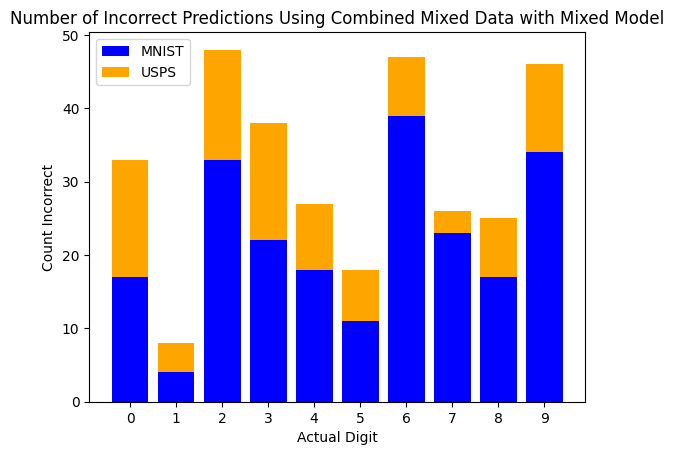

In [174]:
plot_incorrect_2(mixed_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


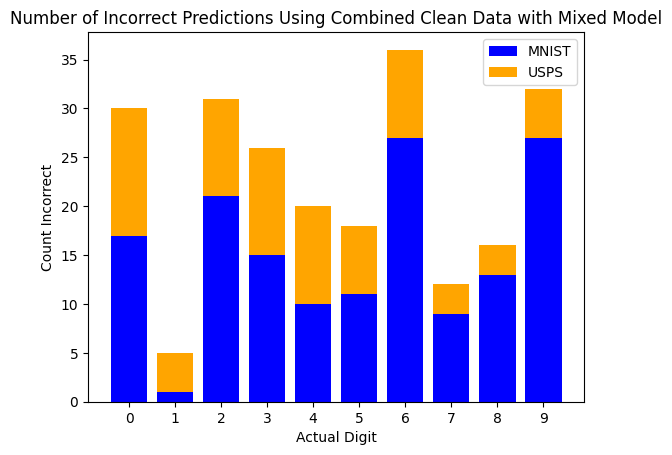

In [175]:
plot_incorrect_2(mixed_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


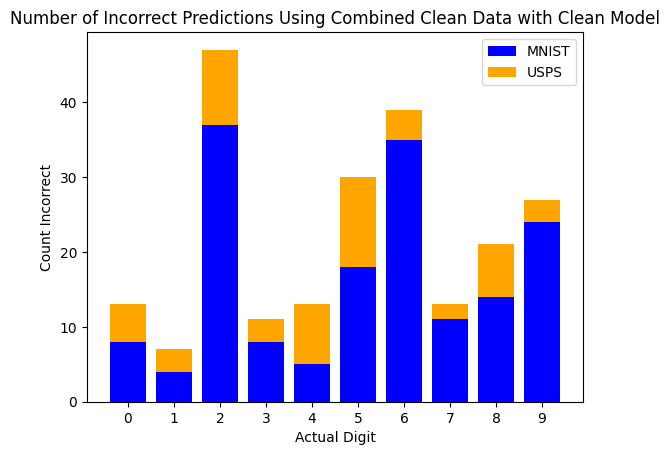

In [176]:
plot_incorrect_2(clean_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Clean Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


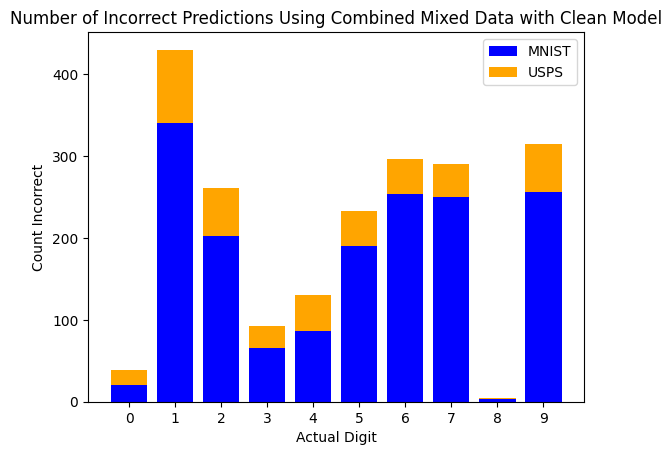

In [177]:
plot_incorrect_2(clean_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Clean Model', 'MNIST', 'USPS')

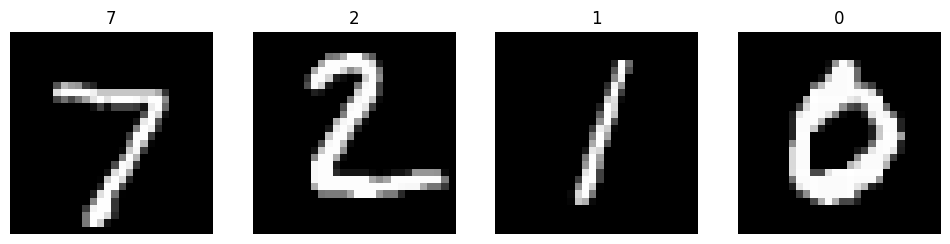

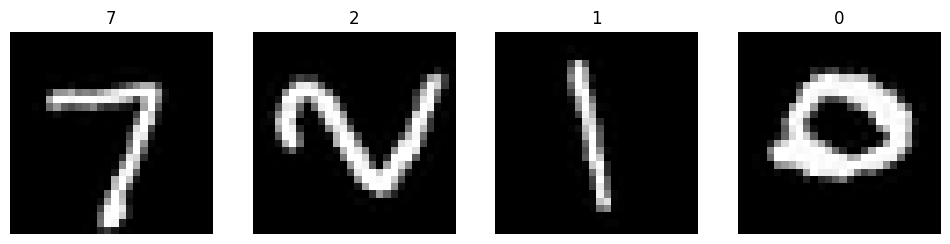

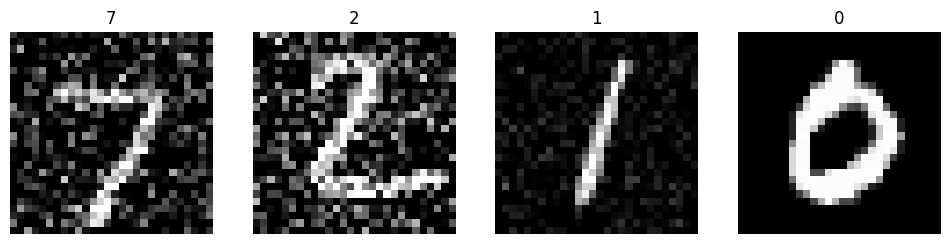

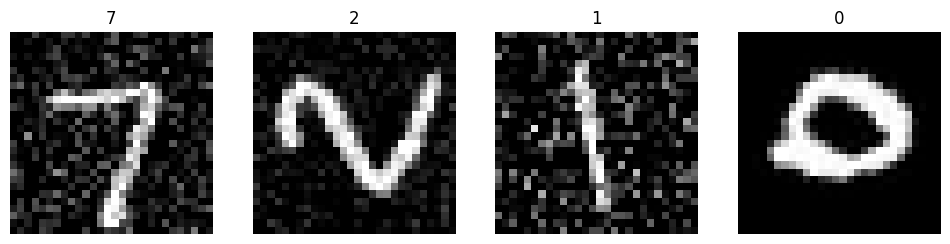

In [178]:
# Testing with rotated datasets
plot_images_in_grid(combined_test_images, combined_test_labels, (1,4))
plot_images_in_grid(combined_rotated_test_images, combined_test_labels, (1,4))

plot_images_in_grid(combined_noisy_test_images, combined_test_labels, (1,4))
plot_images_in_grid(combined_rotated_noisy_test_images, combined_test_labels, (1,4))

In [179]:
rotated_clean_model = clone_model(model)
rotated_clean_model.set_weights(model.get_weights())
rotated_clean_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [180]:
rotated_clean_model.fit(combined_rotated_train_images, combined_train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(combined_rotated_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.4888 - loss: 2.2729 - val_accuracy: 0.8043 - val_loss: 0.6170
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8228 - loss: 0.5533 - val_accuracy: 0.8702 - val_loss: 0.4152
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8853 - loss: 0.3617 - val_accuracy: 0.8876 - val_loss: 0.3525
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9149 - loss: 0.2642 - val_accuracy: 0.9053 - val_loss: 0.3029
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9291 - loss: 0.2146 - val_accuracy: 0.9073 - val_loss: 0.2956
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9422 - loss: 0.1744 - val_accuracy: 0.9226 - val_loss: 0.2609
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9523 - loss: 0.1469 - val_accuracy: 0.9142 - val_loss: 0.2903
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9609 - loss: 0

In [181]:
# Save model
rotated_clean_model.save('./Models/rotated_clean_model.keras')

In [182]:
# Load model
rotated_clean_model = load_model('./Models/rotated_clean_model.keras')

In [183]:
eval_all(rotated_clean_model, True)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.9277
Precision: 0.9292
Recall: 0.9277
F1-Score: 0.9279
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.5858
Precision: 0.8366
Recall: 0.5858
F1-Score: 0.6454
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.8709
Precision: 0.8857
Recall: 0.8709
F1-Score: 0.8718
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.3625
Precision: 0.7607
Recall: 0.3625
F1-Score: 0.3879
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.0984
Precision: 0.2303
Recall: 0.0984
F1-Score: 0.0193

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.8660
Precision: 0.8704
Recall: 0.8660
F1-Score: 0.8668
 1/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/Users/amoskowitz/Desktop/Projects/HandwrittenDigitClassification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.5267
Precision: 0.7747
Recall: 0.5267
F1-Score: 0.5859
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS 25% Dataset:
Accuracy: 0.7783
Precision: 0.8118
Recall: 0.7783
F1-Score: 0.7822
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS 50% Dataset:
Accuracy: 0.3099
Precision: 0.6643
Recall: 0.3099
F1-Score: 0.3351
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS 100% Dataset:
Accuracy: 0.0832
Precision: 0.1857
Recall: 0.0832
F1-Score: 0.0137

Combined:
 83/376 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/Users/amoskowitz/Desktop/Projects/HandwrittenDigitClassification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using Combined Clean Dataset:
Accuracy: 0.9174
Precision: 0.9188
Recall: 0.9174
F1-Score: 0.9176
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using Combined Mixed Dataset:
Accuracy: 0.5759
Precision: 0.8254
Recall: 0.5759
F1-Score: 0.6354
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using Combined Clean Rotated Dataset:
Accuracy: 0.9321
Precision: 0.9330
Recall: 0.9321
F1-Score: 0.9323
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using Combined Mixed Rotated Dataset:
Accuracy: 0.5824
Precision: 0.8461
Recall: 0.5824
F1-Score: 0.6455


In [184]:
rotated_mixed_model = clone_model(model)
rotated_mixed_model.set_weights(model.get_weights())
rotated_mixed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [185]:
rotated_mixed_model.fit(combined_rotated_noisy_train_images, combined_train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(combined_rotated_noisy_test_images, combined_test_labels))

Epoch 1/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.4062 - loss: 2.5128 - val_accuracy: 0.7030 - val_loss: 0.8997
Epoch 2/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7457 - loss: 0.7722 - val_accuracy: 0.8084 - val_loss: 0.5876
Epoch 3/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8405 - loss: 0.4980 - val_accuracy: 0.8448 - val_loss: 0.4777
Epoch 4/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8755 - loss: 0.3864 - val_accuracy: 0.8624 - val_loss: 0.4352
Epoch 5/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8993 - loss: 0.3128 - val_accuracy: 0.8798 - val_loss: 0.3930
Epoch 6/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9171 - loss: 0.2561 - val_accuracy: 0.8847 - val_loss: 0.3677
Epoch 7/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9285 - loss: 0.2212 - val_accuracy: 0.8876 - val_loss: 0.3701
Epoch 8/15
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9381 - loss: 0

In [186]:
# Save model
rotated_clean_model.save('./Models/rotated_mixed_model.keras')

In [187]:
# Load model
rotated_clean_model = load_model('./Models/rotated_mixed_model.keras')

In [188]:
eval_all(rotated_mixed_model, True)

MNIST:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Clean Dataset:
Accuracy: 0.9203
Precision: 0.9216
Recall: 0.9203
F1-Score: 0.9201
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST Mixed Dataset:
Accuracy: 0.9051
Precision: 0.9058
Recall: 0.9051
F1-Score: 0.9048
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 25% Dataset:
Accuracy: 0.9248
Precision: 0.9256
Recall: 0.9248
F1-Score: 0.9247
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 50% Dataset:
Accuracy: 0.9121
Precision: 0.9127
Recall: 0.9121
F1-Score: 0.9119
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing Done Using MNIST 100% Dataset:
Accuracy: 0.8148
Precision: 0.8172
Recall: 0.8148
F1-Score: 0.8143

USPS:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Clean Dataset:
Accuracy: 0.8475
Precision: 0.8575
Recall: 0.8475
F1-Score: 0.8466
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Done Using USPS Mixed Dataset:
Accuracy: 0.8206
Precision: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


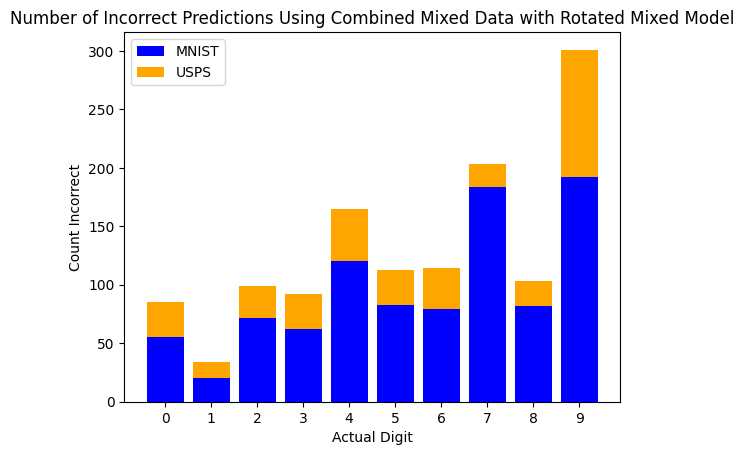

In [189]:
plot_incorrect_2(rotated_mixed_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Rotated Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


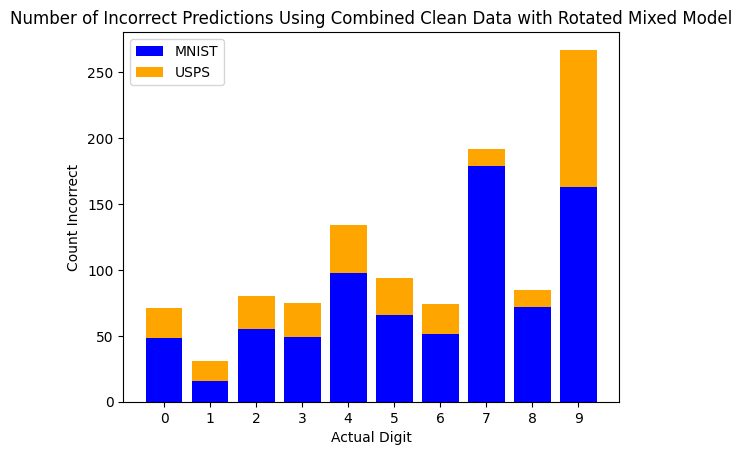

In [190]:
plot_incorrect_2(rotated_mixed_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Rotated Mixed Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


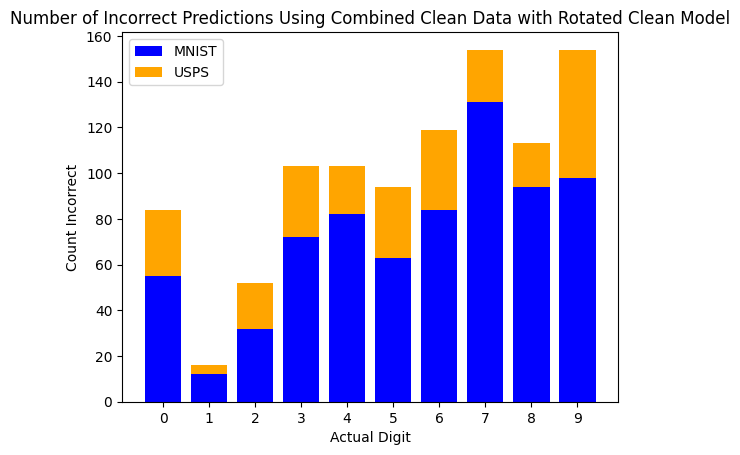

In [191]:
plot_incorrect_2(rotated_clean_model, mnist_test_images, usps_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Clean Data with Rotated Clean Model', 'MNIST', 'USPS')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


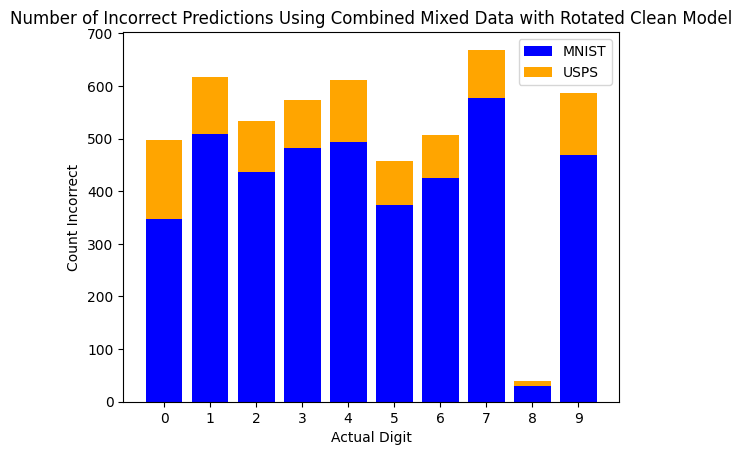

In [192]:
plot_incorrect_2(rotated_clean_model, mnist_noisy_test_images, usps_noisy_test_images, mnist_test_labels, usps_test_labels, 'Number of Incorrect Predictions Using Combined Mixed Data with Rotated Clean Model', 'MNIST', 'USPS')

In [193]:
# function to display incorrect guesses
def display_incorrect(my_model, test_images, test_labels, grid_size, size=3, n_th=0):

  # Find incorrect predictions
  pred = my_model.predict(test_images)
  pred_bin = np.array([np.argmax(x) for x in pred])
  incorrect_pred = np.where(pred_bin != test_labels)
  incorrect_labels = pred_bin[incorrect_pred]
  incorrect_images = test_images[incorrect_pred]
  correct_labels = test_labels[incorrect_pred]

  plot_images_in_grid(incorrect_images, correct_labels, grid_size, size, n_th, incorrect_labels)

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


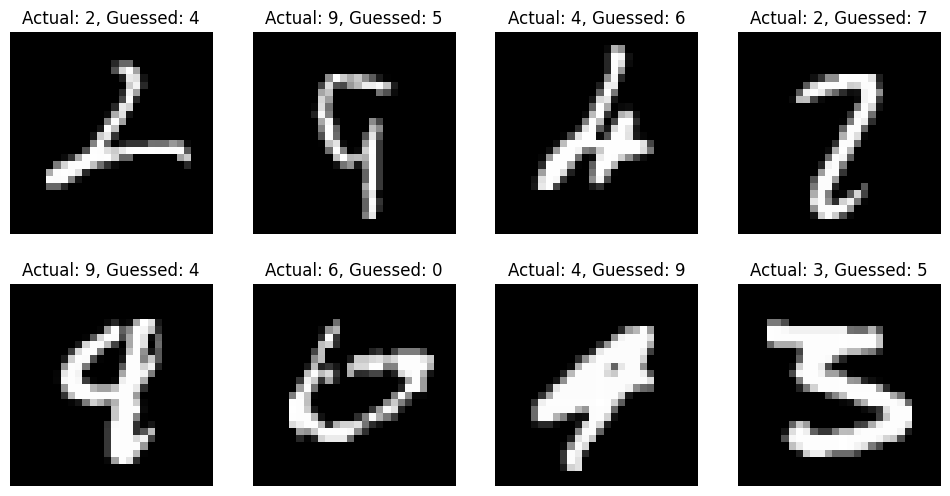

In [194]:
display_incorrect(clean_model, combined_test_images, combined_test_labels, (2, 4))

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


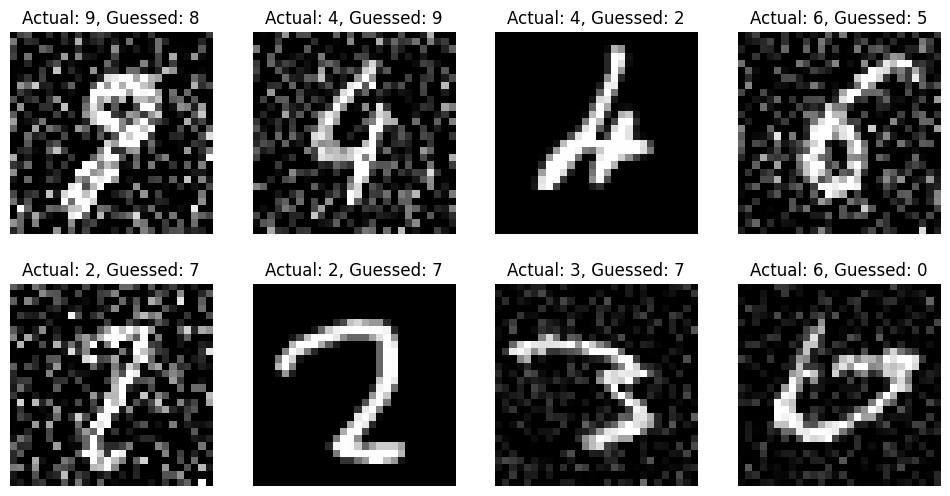

In [195]:
display_incorrect(mixed_model, combined_noisy_test_images, combined_test_labels, (2, 4))

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


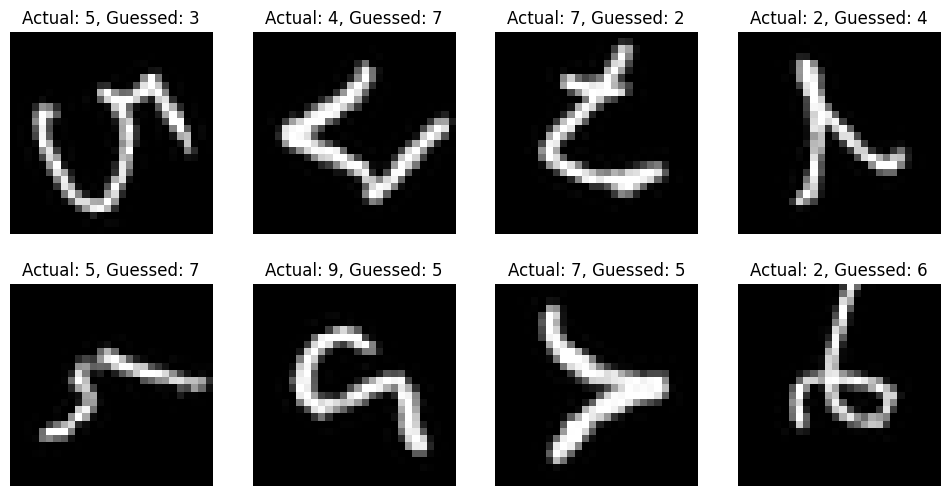

In [196]:
display_incorrect(rotated_clean_model, combined_rotated_test_images, combined_test_labels, (2, 4))

376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


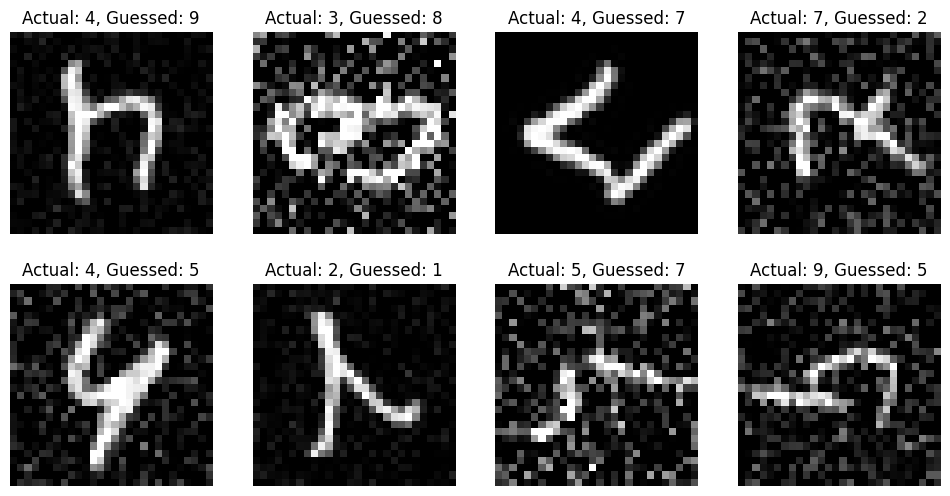

In [197]:
display_incorrect(rotated_mixed_model, combined_rotated_noisy_test_images, combined_test_labels, (2, 4), 3, 0)